In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_tlm.fits")

In [3]:
lmax = hp.Alm.getlmax(tlm.size)
lmax

4096

In [135]:
nside = 2048

In [5]:
tmap = hp.alm2map(tlm, nside=nside)

KeyboardInterrupt: 

In [154]:
clsoriginal = hp.alm2cl(tlm)

In [7]:
nlev_t = 1.

In [6]:
fconv = 180*60/np.pi
fconv = fconv**2.
pixarea = hp.nside2pixarea(nside)
pixarea *= fconv
invtotalnoise = np.array([np.nan_to_num(pixarea/nlev_t**2.)])
invtotalnoise = np.ones_like(tmap)*np.nan_to_num(pixarea/nlev_t**2.)


#invtotalnoise = hp.nside2pixarea(nside, degrees=True) * 60 ** 2 / nlev_t ** 2

invtotalnoise

NameError: name 'nlev_t' is not defined

In [50]:
invtotalnoise_alm = hp.map2alm(invtotalnoise, lmax = lmax)

In [34]:
neff = 10800. / np.sqrt(np.sum(invtotalnoise) / (4.0 * np.pi)) / np.pi

In [35]:
npix = len(tmap)
np.sqrt(4. * np.pi / npix / np.sum(invtotalnoise) * len(np.where(invtotalnoise != 0.0)[0])) * 180. * 60. / np.pi

1.000000000000007

In [26]:
inoisel  = 1. / (neff / 180 / 60 * np.pi) ** 2

In [10]:
tmapreal = tmap * invtotalnoise
tmaprealalm = hp.map2alm(tmapreal, lmax = lmax)

In [27]:
tmapalm = hp.almxfl(tlm, inoisel*np.ones(lmax))

In [28]:
clreal = hp.alm2cl(tmaprealalm)
clalm = hp.alm2cl(tmapalm)

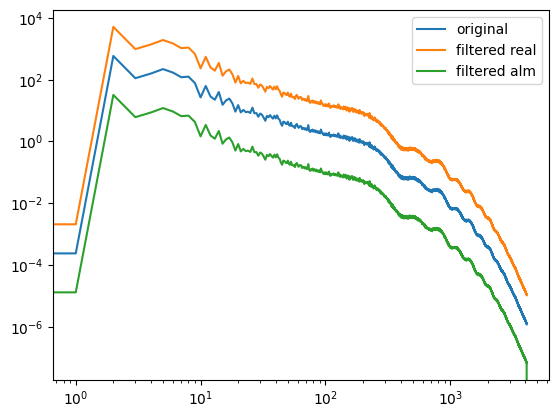

In [32]:
plt.loglog(clsoriginal, label = 'original')
plt.loglog(clreal, label = 'filtered real')
plt.loglog(clalm, label = 'filtered alm')
plt.legend()

In [4]:
slm = np.load("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_bh_s_sim0000bh/normalized_s_slm_it000.npy")

In [47]:
smap = hp.alm2map(slm, nside = nside)

In [52]:
invtotalnoise_s_alm = hp.map2alm(np.nan_to_num(invtotalnoise**-1+smap)**-1, lmax = lmax)

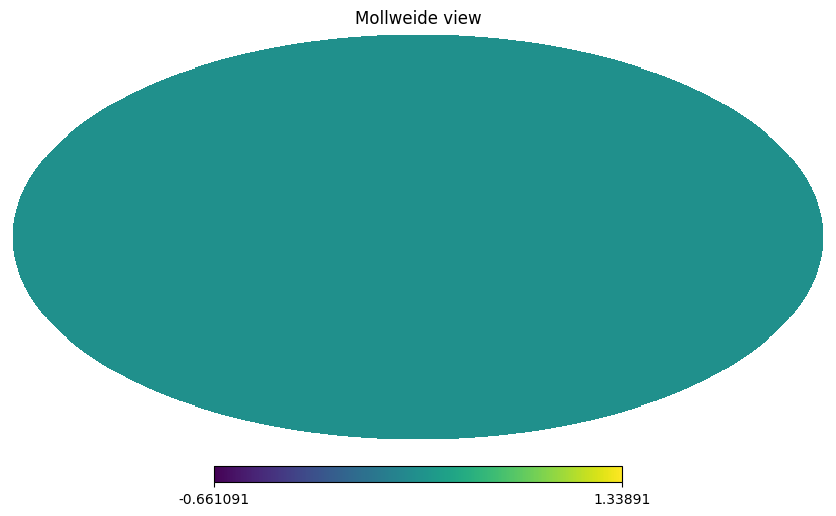

In [55]:
hp.mollview(invtotalnoise**-1.)

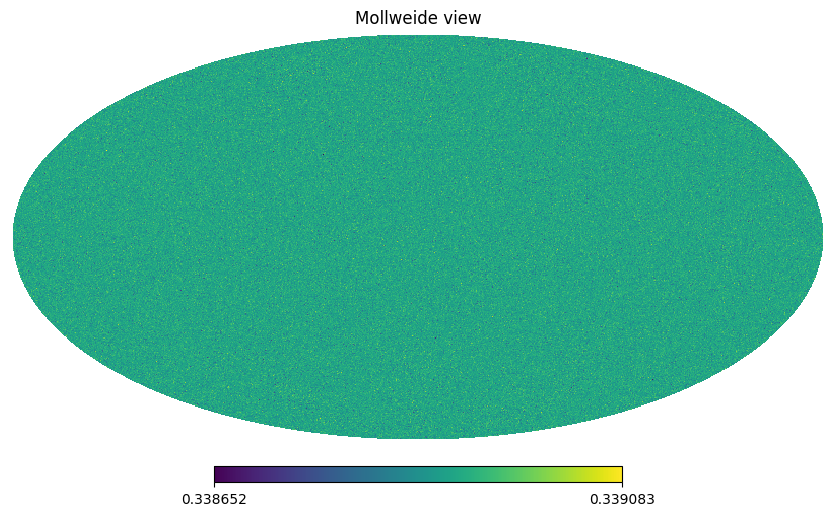

In [53]:
hp.mollview(smap+invtotalnoise**-1.)

In [ ]:
clnoise = hp.alm2cl(invtotalnoise_alm)
clnoise_s = hp.alm2cl(invtotalnoise_s_alm) 

In [5]:
from lenscarf import utils_scarf
from lenspyx.remapping import utils_geom

In [6]:
from lenscarf import utils_hp
from lenspyx.lensing import get_geom 
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from plancklens import utils


nside = 2048
tlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_tlm.fits")
tmapo = hp.alm2map(tlm, nside)

lmax = 3*nside-1 if nside < 2048 else 4500
lmax = min(lmax, hp.Alm.getlmax(tlm.size))
lmax

4096

In [22]:
tmapo/tmap

array([4005265.28652806, 4005265.28649065, 4005265.28646378, ...,
       4005265.28639678, 4005265.28647216, 4005265.28651733])

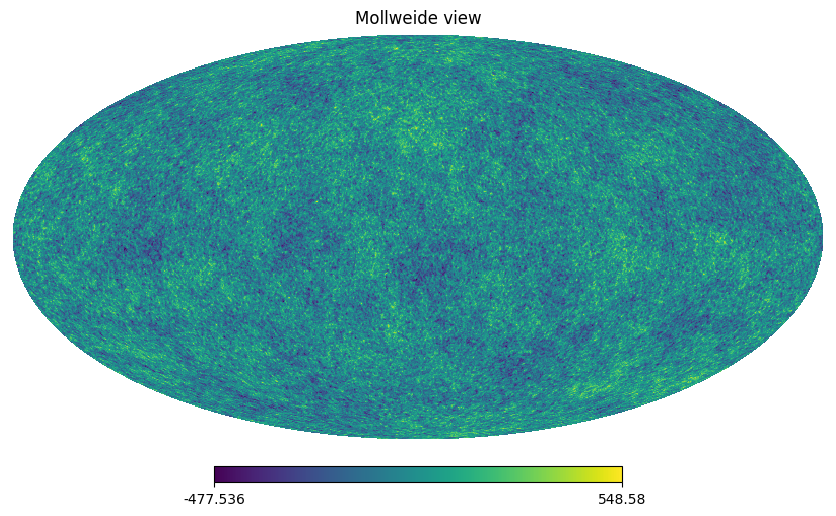

In [23]:
hp.mollview(tmapo)

lmax 4096
datmaps [2.63129719e-07 2.68222043e-07 3.16253307e-07 ... 2.84706977e-07
 2.71598336e-07 2.65319315e-07]
datamaps orig [1.05870428 1.07945196 1.23581738 ... 1.13889166 1.09180884 1.06754287]


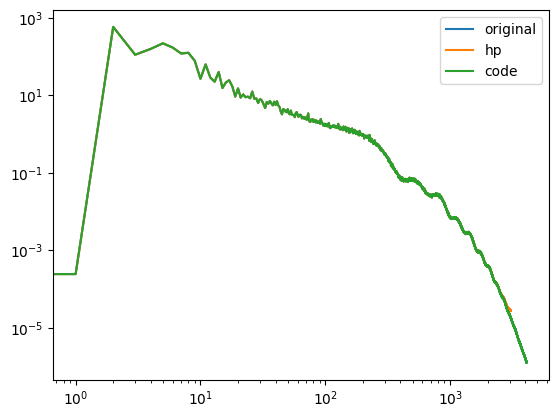

In [28]:
from lenspyx.lensing import get_geom 
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from plancklens import utils


geominfo = ('healpix',{'nside': nside})
geom_ = get_geom(geominfo)

ll = lmax
print("lmax", lmax)
alm2map = lambda x: geom_.alm2map(x, lmax, lmax, 1, (-1., 1.))
map2alm = lambda x: geom_.map2alm(x, lmax, lmax, 1, (-1., 1.))

tmap = alm2map(tlm)
datmaps_alm = map2alm(tmap)
#print(hp.alm2cl(datmaps_alm)/hp.alm2cl(tlm))
#datmaps_alm = utils.alm_copy(datmaps_alm, ll)

datmaps = alm2map(datmaps_alm)
datmaps_alm_ = map2alm(datmaps)

print("datmaps", datmaps/alm2map(datmaps_alm_))
print("datamaps orig", tmap/datmaps)


mappa = map2alm(alm2map(tlm))
mappahp = hp.map2alm(hp.alm2map(tlm, nside = 1024), iter = 0)

#plt.loglog(cls, label = 'input')
plt.loglog(hp.alm2cl(tlm), label = 'original')
plt.loglog(hp.alm2cl(mappahp), label = 'hp')
plt.loglog(hp.alm2cl(datmaps_alm_), label = 'code')
plt.legend()

In [7]:
tmap = alm2map(tlm)
datmaps_alm = map2alm(tmap)

#datmaps_alm = utils.alm_copy(datmaps_alm, ll)

datmaps = alm2map(datmaps_alm)
datmaps_alm_ = map2alm(datmaps)

print()

NameError: name 'alm2map' is not defined

In [13]:
tmap = hp.alm2map(tlm, nside = 2048)

In [15]:
tlmnew = hp.map2alm(tmap, lmax = 4500)

In [16]:
from lenspyx.lensing import get_geom 
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from plancklens import utils


geominfo = ('healpix',{'nside': nside})
geom_ = get_geom(geominfo)


res = geom_.alm2map(tlmnew, 4500, 4500, 1, (-1., 1.))

In [17]:
res

array([-54.17676256, -39.85305837, -17.63271796, ...,  30.42441431,
        42.51898054,  54.77796145])

In [18]:
resalm = geom_.map2alm(res, 4500, 4500, 1, (-1., 1.))

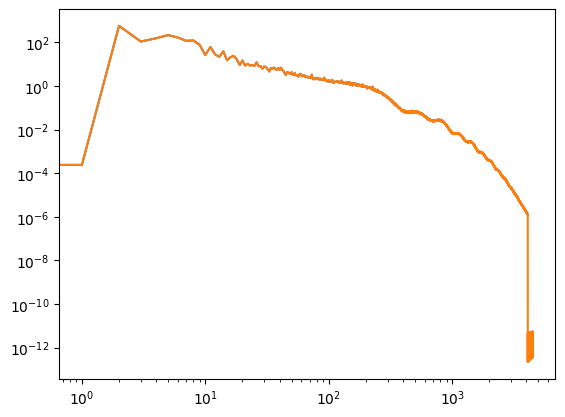

In [19]:
plt.loglog(hp.alm2cl(tlm), label = 'original')
plt.loglog(hp.alm2cl(resalm), label = 'res')

In [72]:
res

array([-54.18849579, -39.86476108, -17.64424917, ...,  30.43769465,
        42.53232662,  54.79136766])

In [67]:
tlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_tlm.fits")
tmap = alm2map(tlm.copy())
datmaps_alm = map2alm(tmap.copy())

In [69]:
tmap

array([-54.18849579, -39.86476108, -17.64424917, ...,  30.43769465,
        42.53232662,  54.79136766])

In [68]:
alm2map(datmaps_alm.copy())

array([-51.18378848, -36.93055615, -14.27739195, ...,  26.72571562,
        38.95583639,  51.3247469 ])

In [47]:
datmaps = alm2map(datmaps_alm)

In [48]:
datmaps

array([-51.18378848, -36.93055615, -14.27739195, ...,  26.72571562,
        38.95583639,  51.3247469 ])

In [43]:
o = alm2map(map2alm(datmaps))

In [44]:
o

array([-48.5658774 , -34.37637631, -11.2715209 , ...,  23.43688813,
        35.81080983,  48.29772364])

In [45]:
o/datmaps

array([3800406.89859015, 3728254.35260625, 3162022.27510249, ...,
       3512383.1950428 , 3681907.68806526, 3769043.34856187])

In [29]:
tmap = alm2map(tlm)
datmaps_alm = map2alm(tmap)

#datmaps_alm = utils.alm_copy(datmaps_alm, ll)

datmaps = alm2map(datmaps_alm)
datmaps_alm_ = map2alm(datmaps)

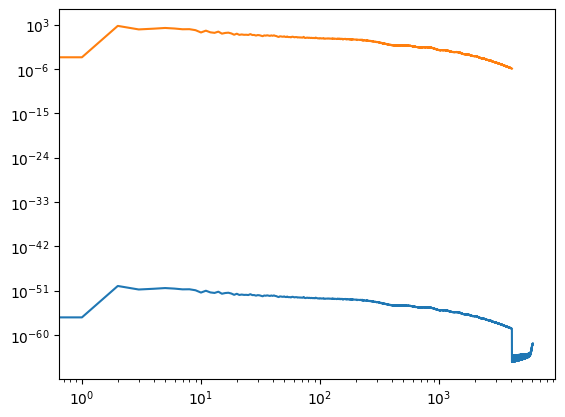

In [12]:
plt.loglog(hp.alm2cl(datmaps_alm))
plt.loglog(hp.alm2cl(tlm))

In [5]:
geom_ = utils_scarf.Geom.get_healpix_geometry(2048, zbounds=(0, 0))
geom_ = utils_geom.Geom(geo.theta.copy(), geo.phi0.copy(), geo.nph.copy(), geo.ofs.copy(), np.ones(len(geo.ofs), dtype=float))

from lenspyx.lensing import get_geom 
geominfo = ('healpix',{'nside': nside})
geom_ = get_geom(geominfo)

alm2map = lambda x, nside: geom_.alm2map(x, 4500, 4500, 1, (-1., 1.))
map2alm = lambda x: geom_.map2alm(x, 4500, 4500, 1, (-1., 1.))

mappa = map2alm(alm2map(tlm, nside))


TypeError: Geom.get_thingauss_geometry() got an unexpected keyword argument 'nside'

In [72]:
lenjob_geometry = utils_geom.Geom.get_thingauss_geometry(4500, 2) #, zbounds=zbounds_len)
pb_ctr, pb_extent = (0., 2 * np.pi)
lenjob_pbgeometry = utils_scarf.pbdGeometry(lenjob_geometry, utils_scarf.pbounds(pb_ctr, pb_extent))

In [73]:
geom_ = lenjob_pbgeometry.geom

In [65]:
beam = hp.gauss_beam(1./60*np.pi/180, lmax = lmax)
lmax

4096

In [66]:
fconv = 180*60/np.pi
fconv = fconv**2.
pixarea = hp.nside2pixarea(2048)
pixarea *= fconv
invtotalnoise = 1.**2. 
invtotalnoise = np.nan_to_num(pixarea/invtotalnoise)

In [116]:
alm2map = lambda x, nside: geom_.alm2map(x, 4500, 4500, 1, (-1., 1.))
map2alm = lambda x: geom_.map2alm(x, 4500, 4500, 1, (-1., 1.))

In [ ]:
utils_geom.Geom
alm2map(map2alm(x, 4500, 4500, 1, (-1., 1.)), 4500, 4500, 1, (-1., 1.))

In [79]:
from lenscarf.utils_hp import alm2cl, almxfl

In [80]:
tmap1024 = alm2map(tlm, nside = 2048)
smap1024 = alm2map(slm, nside = 2048)

In [90]:
from lenscarf.utils_hp import alm2cl, almxfl, Alm

In [87]:
lm = 2048*3-1
tmap = tmap1024.copy()
tmap *= invtotalnoise
print(tmap.mean())
tmapalm = map2alm(tmap)
print(alm2map(tmapalm, 2048).mean())
tmapalm = almxfl(tmapalm, beam, 4500, False)
tmap = alm2map(tmapalm, nside = 2048)
print(tmap.mean())
tmap *= smap1024
print(tmap.mean())
tmapalm = map2alm(tmap)
print(tmap.mean())


0.7220123686826252
0.7220123686815588


ValueError: operands could not be broadcast together with shapes (10131750,) (0,) (10131750,) 

In [ ]:
tmapalm = almxfl(tmapalm, beam, 4000, False)
tmap = alm2map(tmapalm, nside = 2048)
tmap *= invtotalnoise
tmapalm = map2alm(tmap)

AssertionError: (4097, 4500)

In [ ]:
tmap.mean(), tmap1024.mean()

(6.0974308603807875e-05, 0.2446967259477702)

In [ ]:
tmap.std(), tmap1024.std()

(27.102038339729717, 114.70756372473215)

In [ ]:
tmapinv = tmap1024#*invtotalnoise
tmapinvalm = map2alm(tmapinv)

In [ ]:
#hp.alm2cl(hp.map2alm(hp.alm2map(tlm, nside = 1024), lmax = 1024))

In [141]:
from lenscarf import utils_sims
z = utils_sims.ztrunc_sims(None, 1024, [(-1, 1)])

In [128]:
t = alm2map(tlm, nside = 1024)

In [129]:
geom_.map2alm(t, 4500, 4500, 1, (-1., 1.))

TypeError: adjoint_synthesis(): incompatible function arguments. The following argument types are supported:
    1. (*, map: numpy.ndarray, theta: numpy.ndarray, lmax: int, mstart: object = None, nphi: numpy.ndarray, phi0: numpy.ndarray, ringstart: numpy.ndarray, spin: int, lstride: int = 1, pixstride: int = 1, nthreads: int = 1, alm: object = None, mmax: object = None, mode: str = 'STANDARD', theta_interpol: bool = False) -> numpy.ndarray

Invoked with: kwargs: map=array([[ 8.92430703e-12,  7.88665577e-11, -6.82743627e-11, ...,
         2.91458035e-11,  4.96632120e-11, -3.33767959e-11]]), theta=array([3.98679974e-04, 7.97359963e-04, 1.19603998e-03, ...,
       3.14039661e+00, 3.14079529e+00, 3.14119397e+00]), lmax=4500, mmax=4500, nphi=array([ 4,  8, 12, ..., 12,  8,  4], dtype=uint64), spin=0, phi0=array([0.78539816, 0.39269908, 0.26179939, ..., 0.26179939, 0.39269908,
       0.78539816]), nthreads=1, ringstart=array([       0,        4,       12, ..., 50331624, 50331636, 50331644],
      dtype=uint64), alm=None, iter=0

In [143]:
tmappa = hp.alm2map(tlm, nside = 1024)
tmappaz = z.ztruncify(tmappa)
tmappazalm = hp.map2alm(tmappaz, lmax = 1024)

In [144]:
a = map2alm(alm2map(tmappazalm, nside = 1024))

: 

: 

In [ ]:
#plt.loglog(hp.alm2cl(tmapalm), label = 'filtered')
#plt.loglog(hp.alm2cl(tmapinvalm), label = 'inv noise')
plt.loglog(hp.alm2cl(tlm), label = 'original')
plt.loglog(hp.alm2cl(aa), label = 'iter = 0')
plt.loglog(hp.alm2cl(a), color = "black")
plt.loglog(hp.alm2cl(adouble), color = "red")
plt.legend()

In [131]:
adouble = map2alm(alm2map(a, nside = 1024))

In [119]:
aa = hp.map2alm(hp.alm2map(tlm, nside = 1024), lmax = 1024, iter = 0)

In [104]:
tlm

array([ 7.61504677e-03+0.j        , -6.08224545e-03+0.j        ,
        1.62052028e+01+0.j        , ..., -5.42092422e-04-0.00082341j,
       -1.01850381e-04+0.00035973j, -5.23904742e-04-0.00084438j])

In [105]:
a

array([ 7.61590296e-03+0.j        , -6.08012383e-03+0.j        ,
        1.62052047e+01+0.j        , ...,  3.88244067e-04+0.00063964j,
       -1.85077563e-03+0.00308627j,  7.63313973e-04+0.00321943j])

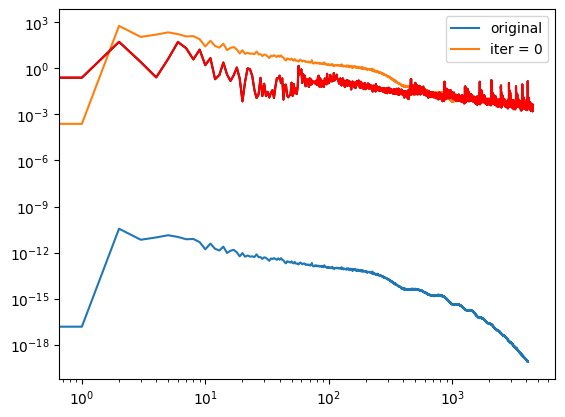

In [132]:
#plt.loglog(hp.alm2cl(tmapalm), label = 'filtered')
#plt.loglog(hp.alm2cl(tmapinvalm), label = 'inv noise')
plt.loglog(hp.alm2cl(tlm), label = 'original')
plt.loglog(hp.alm2cl(aa), label = 'iter = 0')
plt.loglog(hp.alm2cl(a), color = "black")
plt.loglog(hp.alm2cl(adouble), color = "red")
plt.legend()

In [41]:
cls_slm = hp.alm2cl(slm)

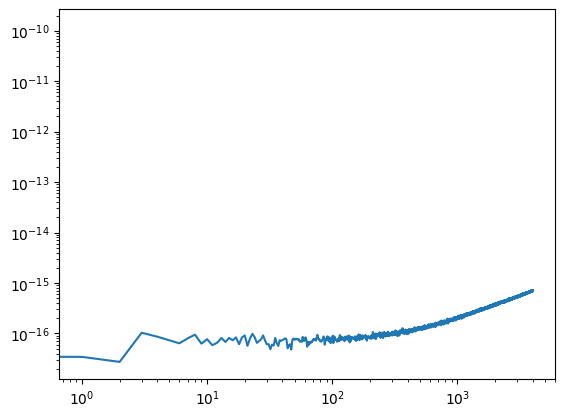

In [46]:
plt.loglog(cls_slm)

In [69]:
## generate a point sources map for healpix, with given flux
## the point sources are randomly distributed on the sky, and they are Poisson distributed
## the flux is given in Jy
## the map is generated at a given nside
## the number for point sources is given by the flux and the flux limit

##get the radio point sources popultionation using a power law for the number counts
## use formula (29) from Osborner et al 2013
def dNdS(S, N0, beta):
    return N0/S**beta

beta = 2.15
Smax = 200*1e-3 #Jy
Smin = 1e-20

N0 = 12 #Jy^{1.15}sr^{-1}

## get the number of point sources in the sky
## integrate the number counts
## use formula (30) from Osborner et al 2013
def N( Smax, Smin, N0, beta):
    return N0/(1-beta)*(Smax**(1-beta)-Smin**(1-beta))

Nsources = N(Smax, Smin, N0, beta)
Nsources


1.0434782608695609e+24

In [128]:
T0 = 2.7255

def dBdT(freq_GHz, T):
    '''d(blackbody)/dT, such that
    dI = d(blackbody)/dT * dT
    input: nu [Hz], T thermo temperature of the black body [K]
    output in SI: [W / Hz / m^2 / sr / K]
    '''
    h = 6.63e-34
    kB = 1.380658e-23
    c = 29979245800.
    nu = freq_GHz*1.e9

    x = h*nu/(kB*T)
    result = 2.*h**2*nu**4
    result /= kB*T**2*c**2
    result *= np.exp(x) / (np.exp(x) - 1.)**2

    return result

In [368]:
factor = (1.e-26) #from Jy to W/m^2/Hz
factor *= 1/dBdT(143, T0)
factor*1e6

26.335152906368616

In [372]:
def JyPerSter_to_dimensionless(nu,Tcmb = 2.726):
    """
    nu in GHz
    Tcmb in Kelvin
    Divide by this number to convert JyPerSter to deltaT/T
    """
    kB = 1.380658e-16
    h = 6.6260755e-27
    c = 29979245800.
    nu = nu*1.e9
    x = h*nu/(kB*Tcmb)
    cNu = 2*(kB*Tcmb)**3/(h**2*c**2)*x**4/(4*(np.sinh(x/2.))**2)
    cNu *= 1e23
    return cNu

In [373]:
1e6 / JyPerSter_to_dimensionless(143) * 2.7255e6

2631.0726711925704

In [145]:
factor = (1.e-26) #**3.85 #from Jy to W/m^2/Hz
factor *= 1/dBdT(148, T0)
factor = factor**4

Sarray = np.linspace(1e-5, 0.2, 1000)

s4 = np.trapz(dNdS(Sarray, N0, beta)*Sarray**4., Sarray)
s4

#convert to muK^4

s4 *= factor
s4

1.7955443432160873e-20

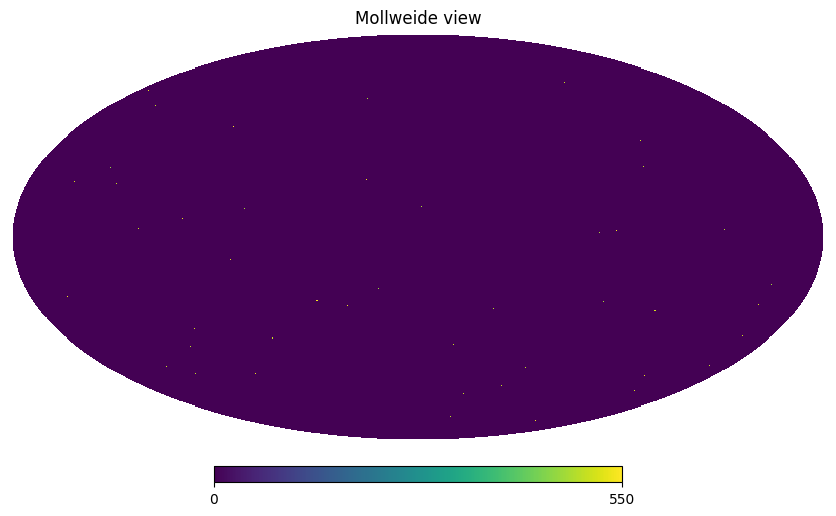

In [398]:
NN = 10000
Nsources = np.random.poisson(NN)
positions = np.random.randint(0, hp.nside2npix(nside), Nsources)
Amplitude_of_Sources = 500
amplitudes = np.random.poisson(Amplitude_of_Sources, Nsources)

mappa = np.zeros(hp.nside2npix(nside))
mappa[positions] = amplitudes

hp.mollview(mappa)

In [264]:
alm = hp.map2alm(mappa, lmax = lmax)

In [265]:
def randomizing_fg(mappa: np.ndarray):
     f = lambda z: np.abs(z) * np.exp(1j*np.random.uniform(0., 2.*np.pi, size = z.shape))
     return f(mappa)

In [266]:
almrandomized = randomizing_fg(alm)

In [294]:
hp.write_alm("almrandomizedpointsources.fits", almrandomized, overwrite = True)

In [296]:
hp.write_alm("almpointsources.fits", alm, overwrite = True)

In [267]:
!pwd

/Users/omard/Documents/projects/fgcmblensing/iterativeforegroundsfullsky/itfgs/notebooks


In [268]:
cls = hp.alm2cl(alm)

In [269]:
clsrand = hp.alm2cl(almrandomized)

In [270]:
clsrand

array([1.20290581e-05, 7.89284449e-06, 1.33934631e-05, ...,
       1.25599266e-05, 1.21456341e-05, 1.21734190e-05])

In [271]:
cls

array([1.26759519e-01, 7.93378443e-06, 1.33954649e-05, ...,
       1.25604922e-05, 1.21456345e-05, 1.21739371e-05])

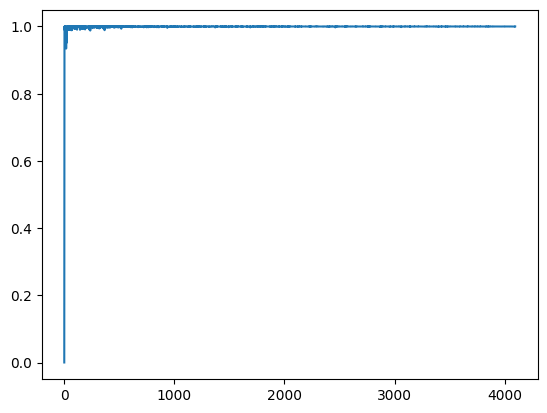

In [272]:
plt.plot(clsrand/cls)

In [374]:
path = "/Users/omard/Downloads/SCRATCHFOLDER/SKYSIMS/WEBSKYSIMS/"
nome = "alm_cib_nu0143.fits"
alm = hp.read_alm(path+nome)
clcib = hp.alm2cl(alm*2631.0726711925704)

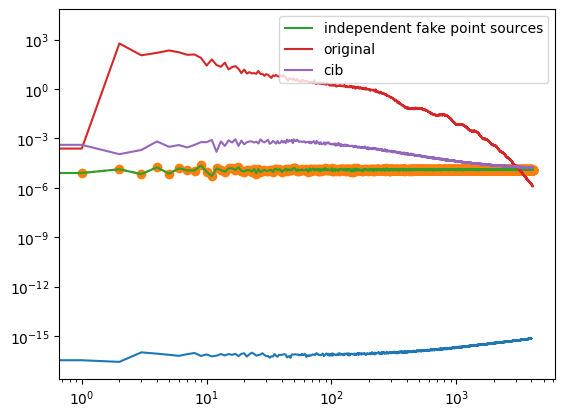

In [484]:
plt.loglog(cls_slm)
plt.loglog(clsrand, ls = '--', marker = "o")
plt.loglog(cls, label = "independent fake point sources")
plt.loglog(clsoriginal, label = 'original')
plt.loglog(clcib, label = 'cib')
plt.legend()

## Apply plancklens QE

In [349]:
import scipy
from scipy import signal


def bin_theory(l, cl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    return cl


bin_edges = np.arange(10, 4500, 50)

els = bin_edges[:-1] + np.diff(bin_edges)/2

In [350]:
from plancklens import utils

plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_0_lmax5120.fits")
plmin = utils.alm_copy(plmin, lmax=4500)

In [390]:
pin = hp.alm2map(plmin, nside = 2048)

In [473]:
probability = np.random.poisson(abs(pin)*2)

In [474]:
positions = np.where(probability > 0)[0]

In [475]:
len(positions)

7981

In [476]:
mappa = np.zeros(hp.nside2npix(2048))

amplitudes = np.random.poisson(200, len(positions))

mappa[positions] = amplitudes


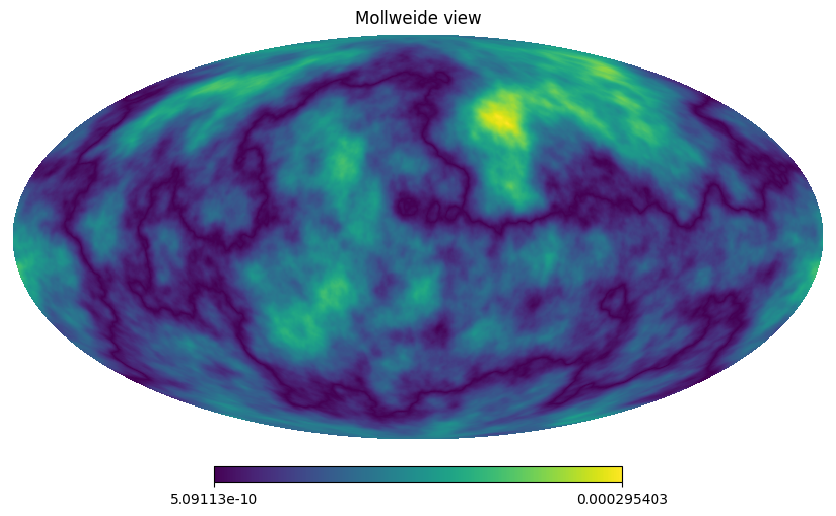

In [477]:
hp.mollview(abs(pin))

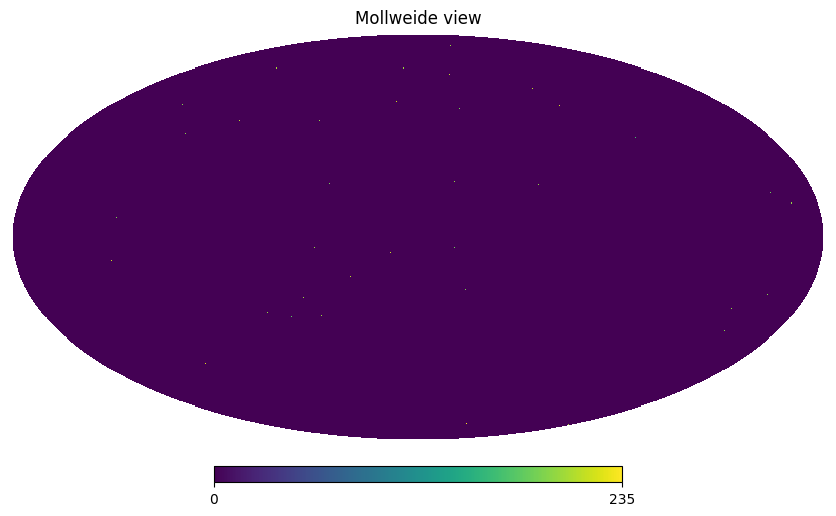

In [478]:
hp.mollview(mappa)

In [479]:
almmappa = hp.map2alm(mappa, lmax = 4500)

In [480]:
crosscorr = hp.alm2cl(almmappa, plmin)


In [481]:
auto = hp.alm2cl(almmappa)


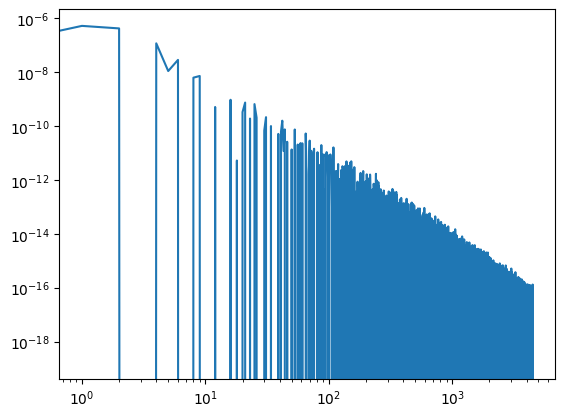

In [482]:
#plt.loglog(abs(crosscorr))
plt.loglog(crosscorr)

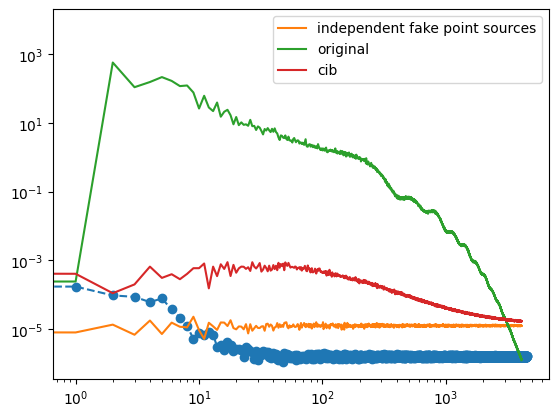

In [483]:
plt.loglog(auto, ls = '--', marker = "o")
plt.loglog(cls, label = "independent fake point sources")
plt.loglog(clsoriginal, label = 'original')
plt.loglog(clcib, label = 'cib')
plt.legend()

In [351]:
inin = hp.alm2cl(plmin)

In [469]:
directory = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/"
get_specific_dir = lambda s, k, id, v: directory+f"lenscarfrecsCIB{s}/{k}_sim{id:04}{v}"
specific_name = ["NG", ""]
ks = ["ptt", "ptt_bh_s"]
vs = ["qe", "bh"]
cases = ["cib", "cibrand"]
ids = np.arange(3)

In [470]:
results = {}

for k, v in zip(ks, vs):
    temp = {}
    for case, specific in zip(cases, specific_name):
        mean = 0
        meanc = 0
        for id in ids:
            print(get_specific_dir(specific, k, id, v+case)+"/normalized_phi_plm_it000.npy")
            rec = np.load(get_specific_dir(specific, k, id, v+case)+"/normalized_phi_plm_it000.npy")
            mean += hp.alm2cl(rec, rec)
            meanc += hp.alm2cl(rec, plmin)
        mean /= len(ids)
        meanc /= len(ids)
        temp[case] = np.c_[mean, meanc]
    results[k] = temp

/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIBNG/ptt_sim0000qecib/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIBNG/ptt_sim0001qecib/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIBNG/ptt_sim0002qecib/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIB/ptt_sim0000qecibrand/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIB/ptt_sim0001qecibrand/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIB/ptt_sim0002qecibrand/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIBNG/ptt_bh_s_sim0000bhcib/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecsCIBNG/ptt_bh_s_sim0001bhcib/normalized_phi_plm_it

In [471]:
ls = np.arange(0, len(inin))

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_41370/3006373252.py:12: RuntimeWarning: invalid value encountered in divide
  p = plt.plot(diff[:, i]/inin, alpha = 0.5)


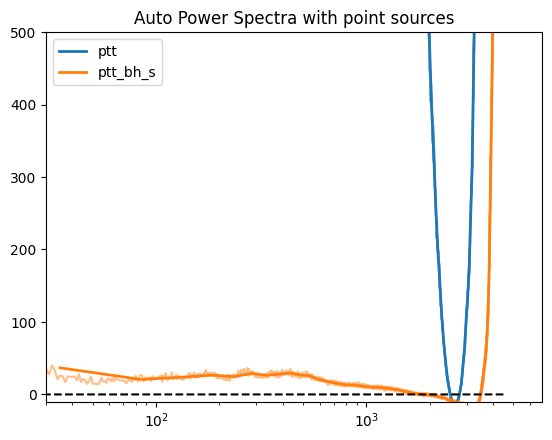

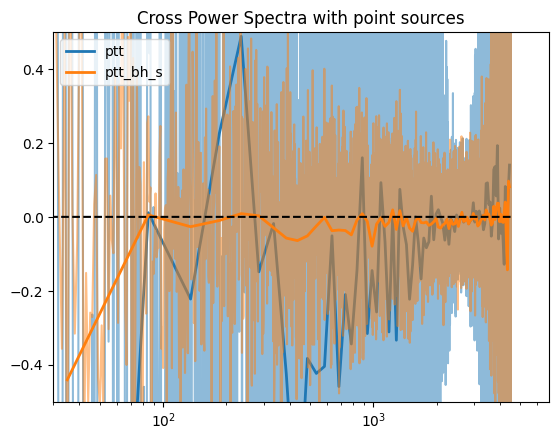

In [472]:
titles = ["Auto", "Cross"]
ylims = [(-10, 500), (-0.5, 0.5)]
for i in range(2):
    plt.title(f"{titles[i]} Power Spectra with point sources")

    A, B = cases

    for k, v in results.items():
        diff = v[A]-v[B] #NG-RandNG
        diff_binned = bin_theory(ls, diff[:, i], bin_edges)
        inin_binned = bin_theory(ls, inin, bin_edges)
        p = plt.plot(diff[:, i]/inin, alpha = 0.5)
        plt.plot(els, diff_binned/inin_binned, lw = "2", label = k, color = p[0].get_color())#, color = p[0].get_color(), label = k)
    plt.plot(ls, ls*0., ls = "--", color = "k")
    plt.ylim(*ylims[i])
    plt.xscale("log")
    plt.xlim(30)
    plt.legend()
    plt.show()